<a href="https://colab.research.google.com/github/ChenDelong1999/RemoteCLIP/blob/main/RemoteCLIP_colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [RemoteCLIP🛰️: A Vision Language Foundation Model for Remote Sensing](https://arxiv.org/abs/2306.11029)

[Fan Liu (刘凡)](https://multimodality.group/author/%E5%88%98%E5%87%A1/)*
[Delong Chen (陈德龙)](https://chendelong.world/)*
Zhangqingyun Guan (管张青云)
Xiaocong Zhou (周晓聪)
Jiale Zhu (朱佳乐)
[Jun Zhou (周峻)](https://experts.griffith.edu.au/7205-jun-zhou)

\* Equal Contribution

[Github repository](https://github.com/ChenDelong1999/RemoteCLIP/)

[Huggingface model weights](https://huggingface.co/chendelong/RemoteCLIP/tree/main)

-> Run on GPU runtime (top right corner) <-

In [1]:
# @title Install libraries
%%capture
!pip install huggingface_hub open_clip_torch
!git clone https://github.com/ChenDelong1999/RemoteCLIP/

In [2]:
# @title Load packages and download model weights
from huggingface_hub import hf_hub_download
import torch, open_clip
from PIL import Image
from IPython.display import display

# for model_name in ['RN50'] #, 'ViT-B-32', 'ViT-L-14']: #faster loading
for model_name in ['RN50', 'ViT-B-32', 'ViT-L-14']: #all models
    checkpoint_path = hf_hub_download("chendelong/RemoteCLIP", f"RemoteCLIP-{model_name}.pt", cache_dir='checkpoints')
    print(f'{model_name} is downloaded to {checkpoint_path}.')

RN50 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-RN50.pt.
ViT-B-32 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-B-32.pt.
ViT-L-14 is downloaded to checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38/RemoteCLIP-ViT-L-14.pt.


In [3]:
# @title Select Model
model_name = 'RN50' # @param ['RN50', 'ViT-B-32', 'ViT-L-14']
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

path_to_your_checkpoints = 'checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38'

ckpt = torch.load(f"{path_to_your_checkpoints}/RemoteCLIP-{model_name}.pt", map_location="cpu")
message = model.load_state_dict(ckpt)
print(message)
model = model.cuda().eval()

<All keys matched successfully>


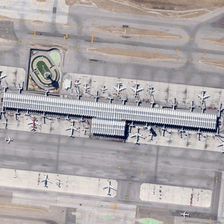

In [4]:
# @title Text caption queries
text_queries = [
    "A busy airport with many aeroplanes.",
    "Satellite view of Hohai university.",
    "Satellite view of sydney",
    "A building next to a lake.",
    "Many people in a stadium.",
    "a cute cat",
]
text = tokenizer(text_queries)
image = Image.open("/content/RemoteCLIP/assets/airport.jpg").convert('RGB') #convert to rgb allows it to display as png if the jpg is in cmyk
display(image)


In [5]:
# @title Predicted probabilities
image = preprocess(image).unsqueeze(0)

with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image.cuda())
    text_features = model.encode_text(text.cuda())
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1).cpu().numpy()[0]

print(f'Predictions of {model_name}:')
for query, prob in zip(text_queries, text_probs):
    print(f"{query:<40} {prob * 100:5.1f}%")

Predictions of RN50:
A busy airport with many aeroplanes.      99.6%
Satellite view of Hohai university.        0.0%
Satellite view of sydney                   0.4%
A building next to a lake.                 0.0%
Many people in a stadium.                  0.0%
a cute cat                                 0.0%
